## Introduction

This jupyter notebook aims to give a deepening regarding the different evaluation metrics used in the [DCASE 2021 Task 4](http://dcase.community/challenge2021/task-sound-event-detection-and-separation-in-domestic-environments). 

In particular, an experiment will be executed with the goal of studying to what extend changing the ground-truth and considering the modified ground-truth as the original ones will affect and impact the PSDS metrics. More information regarding the differences between event-based, collar-based, and intersection-based metrics could be found in this Jupyter Notebook [[1]](#References).

For more information about PSDS metrics, the user is referred to [[2]](#References).

The functions, files and predictions used in this jupyter notebook are the same used in the baseline code. 

## Experiment with modified ground truth (onset/offset)

In this first experiment, we modify the ground truth class labels and timestamps. In the first experiment, we will take the ground-truth, we will change the onset and offset label by adding a value that is going to be drawn randomly between 0% and 100% of the original event length. The percentage to add to the event length is chosen by the user through a slider.

For this experiment, we are going to use the predictions from the baseline, which are saved inside the folder `meta`. We will focus only on the metrics related to the **student** system. If you want to consider the metrics for the teacher too, you can follow the same process replacing the student predictions with the teacher predictions, which you will find in the `meta` folder.

First, let's import all the modules needed to run the code, and let's define the functions needed to calculate the metrics.

### Hands-on

First of all, let's import all the libraries that we will need to run the code.

In [1]:
import os
import sed_eval 
import pandas as pd
import numpy as np

import ipywidgets as widgets
import random
import glob
import os.path as osp
from psds_eval import plot_psd_roc
import matplotlib.pyplot as plt
from psds_eval import PSDSEval, plot_per_class_psd_roc

import warnings
warnings.filterwarnings("ignore")

Let's read and import the ground_truth labels and save them in the `gt` dataframe. 

In [2]:
# read ground truth labels and save them in the gt dataframe
ground_truth_file="meta/validation.tsv"
gt = pd.read_csv(ground_truth_file, sep="\t")
gt.head() # will print only the 5 rows of the gt dataframe

,filename,onset,offset,event_label
0,Y00pbt6aJV8Y_350.000_360.000.wav,0.00,9.971,Vacuum_cleaner
1,Y00pK0GMmE9s_70.000_80.000.wav,0.00,10.000,Vacuum_cleaner
2,Y02sD1KJeoGA_50.000_60.000.wav,0.00,10.000,Frying
3,Y0bjUq9XMMmQ_30.000_40.000.wav,0.00,10.000,Frying
4,Y0cH_NlhhMAs_30.000_40.000.wav,1.71,6.005,Cat


Let's import all the function needed to process the data. 
The functions have been directly copied from the `desed` package or from the baseline code in order to properly process the data.

The function `create_folder` will create the folder (and its parent folders) which path is given as input. 

In [3]:
def create_folder(folder, exist_ok=True, delete_if_exists=False):
    """ Create folder (and parent folders) if not exists.

    Args:
        folder: str, path of folder(s) to create.
        delete_if_exists: bool, True if you want to delete the folder when exists

    Returns:
        None
    """
    if not folder == "":
        if delete_if_exists:
            if os.path.exists(folder):
                shutil.rmtree(folder)
                os.mkdir(folder)

        os.makedirs(folder, exist_ok=exist_ok)

The function `save_tsv` save to the filepath given as input the dataframe given as input.

In [4]:
def save_tsv(df, filepath):
    create_folder(osp.dirname(filepath))
    df = df.sort_values("filename")
    df.to_csv(filepath, index=False, sep="\t", float_format="%.3f")

Now, let's import all the necessary functins which will allow us to check if the labels are correct and if the onset and offset value are between the file duration. 

The function `sanity_check` check that onset and offset are in the boundaries. 

In [5]:
def sanity_check(df, length_sec=None):
    """ Check that onset and offset are in the boundaries
    Args:
        df: pandas.DataFrame, dataframe defining 'onset' and 'offset' columns.
        length_sec: float, optional, if defined it is the maximum length of a file.

    Returns:
        pandas.DataFrame, the updated dataframe.
    """
    if not df["onset"].dtype == np.float and df["offset"].dtype == np.float:
        df[["onset", "offset"]] = df[["onset", "offset"]].astype(float)
    if length_sec is not None:
        df["offset"].clip(upper=length_sec, inplace=True)
    df["onset"].clip(lower=0, inplace=True)
    df = df.round(3)
    return df

The function `_post_process_labels_file` checks the annotation. 
In particular:
- Merge overlapping annotations of the same class
- Merge overlapping annotations having less than 150ms between them (or 400ms between the onsets).
- Make minimum length of events = 250ms.

In [6]:
def _post_process_labels_file(
    df_ann, length_sec=None, min_dur_event=0.250, min_dur_inter=0.150, rm_non_noff=True
):
    """ Check the annotations,
        * Merge overlapping annotations of the same class
        * Merge overlapping annotations having less than 150ms between them (or 400ms between the onsets).
        * Make minimum length of events = 250ms.
    Args:
        df_ann: pd.DataFrame object, containing the annotations to post_process
        length_sec: float, duration of the file to post_process
        min_dur_event: float, optional in sec, minimum duration of an event
        min_dur_inter: float, optional in sec, minimum duration between 2 events
        rm_non_noff: bool, whether to delete the additional _nOn _nOff at the end of labels.

    Returns:

    """

    df = df_ann.copy()
    if rm_non_noff:
        df["event_label"] = df["event_label"].apply(
            lambda x: str(x).replace("_nOff", "").replace("_nOn", ""))
        
    fix_count = 0
    df = sanity_check(df, length_sec)
    df = df.sort_values("onset")
    for class_name in df["event_label"].unique():
        i = 0
        while i is not None:
            #print(length_sec)
            indexes = df[df["event_label"] == class_name].index
            ref_onset = df.loc[indexes[i], "onset"]
            ref_offset = df.loc[indexes[i], "offset"]
            if ref_offset - ref_onset < min_dur_event:
                ref_offset = ref_onset + min_dur_event
                # Too short event, and at the offset (onset sorted),
                # so if it overlaps with others, they are also too short.
                if ref_offset > length_sec:
                    df = df.drop(indexes[i:])
                    fix_count += len(indexes[i:])
                    break
                else:
                    df.loc[indexes[i], "offset"] = ref_onset + min_dur_event
            j = i + 1
            while j < len(indexes):
                if df.loc[indexes[j], "offset"] < ref_offset:
                    df = df.drop(indexes[j])
                    fix_count += 1
                elif df.loc[indexes[j], "onset"] - ref_offset < min_dur_inter:
                    df.loc[indexes[i], "offset"] = df.loc[indexes[j], "offset"]
                    ref_offset = df.loc[indexes[j], "offset"]
                    df = df.drop(indexes[j])
                    fix_count += 1
                elif (
                    df.loc[indexes[j], "onset"] - ref_onset
                    < min_dur_event + min_dur_inter
                ):
                    df.loc[indexes[i], "offset"] = df.loc[indexes[j], "offset"]
                    ref_offset = df.loc[indexes[j], "offset"]
                    df = df.drop(indexes[j])
                    fix_count += 1
                else:
                    # Quitting the loop
                    break
                j += 1
            i += 1
            if i >= len(df[df["event_label"] == class_name].index):
                i = None
    df = df.sort_values("onset")
    return df, fix_count

The function `post_process_df_labels` post-processes the labels checking their validity. 
In particular:
- overlapping events of the same class are mixed
- if silence < 150ms between two conscutive events of the same class, they are mixed
- if event < 250ms, the event lasts 250ms   

In [7]:
def post_process_df_labels(
    df,
    files_duration=None,
    output_tsv=None,
    min_dur_event=0.250,
    min_dur_inter=0.150,
    rm_nOn_nOff=True,
):
    """ clean the .txt files of each file. It is the same processing as the real data
        - overlapping events of the same class are mixed
        - if silence < 150ms between two conscutive events of the same class, they are mixed
        - if event < 250ms, the event lasts 250ms

        Args:
            df: pd.DataFrame, dataframe of annotations containing columns ["filename", "onset", "offset", "event_label"]
            files_duration: pd.DataFrame or float, dataframe containing columns ["filename", "duration"]
                indicating the lengh of a file.
                or float being the length of all the files if all the files have the same duration.
            output_tsv: str, optional, tsv with all the annotations concatenated
            min_dur_event: float, optional in sec, minimum duration of an event
            min_dur_inter: float, optional in sec, minimum duration between 2 events
            rm_nOn_nOff: bool, whether to delete the additional _nOn _nOff at the end of labels.

        Returns:
            None
        """
    
    fix_count = 0
    result_df = pd.DataFrame()
    for fn in df.filename.unique():
        if files_duration is not None:
            if type(files_duration) is pd.DataFrame:
                length_sec_dict = files_duration[files_duration.filename == fn].duration 
                # TODO: But this line????
                length_sec = length_sec_dict[length_sec_dict.keys()[0]]
            elif type(files_duration) in [float, int]:
                length_sec = files_duration
            else:
                raise TypeError("files duration is pd.DataFrame or a float only")
        else:
            length_sec = None
        df_ann, fc = _post_process_labels_file(
            df[df.filename == fn], length_sec, min_dur_event, min_dur_inter, rm_nOn_nOff
        )
        fix_count += fc

        result_df = result_df.append(
            df_ann[["filename", "onset", "offset", "event_label"]], ignore_index=True
        )

    if output_tsv:
        save_tsv(result_df, output_tsv)

    return result_df


We will also need to the function to compute the PSDS score from different operating points. 
The function `compute_psds_from_operating_points` computes the PSDS metrics. The different parameters allow to define different scenarios with different contraints. 

In [8]:
def compute_psds_from_operating_points(
    prediction_dfs,
    gt,
    durations,
    dtc_threshold=0.5,
    gtc_threshold=0.5,
    cttc_threshold=0.3,
    alpha_ct=0,
    alpha_st=0,
    max_efpr=100,
    save_dir=None,
):

    psds_eval = PSDSEval(
        ground_truth=gt,
        metadata=durations,
        dtc_threshold=dtc_threshold,
        gtc_threshold=gtc_threshold,
        cttc_threshold=cttc_threshold,
    )
    
    

    for i, k in enumerate(prediction_dfs.keys()):
        k = round(k, 2)
        det = prediction_dfs[k]
        # see issue https://github.com/audioanalytic/psds_eval/issues/3
        #det["index"] = range(1, len(det) + 1)
        #det = det.set_index("index")
        psds_eval.add_operating_point(
            det, info={"name": f"Op {i + 1:02d}", "threshold": k}
        )

    psds_score = psds_eval.psds(alpha_ct=alpha_ct, alpha_st=alpha_st, max_efpr=max_efpr)

    return psds_score, psds_eval

Now, all the needed functions have been declared. 
Let's start the experiment!

Let's make a copy of the `gt` dataframe so it will be possible to compare the randomized ground-truth the original one. We will also remove all the null rows. 

In [9]:
# copy the ground-truth in the gt_copy dataframe and delete null rows. 
gt_copy = gt.copy(deep=True)
res = np.where(pd.isnull(gt_copy))
res_df = gt_copy.drop(labels=res[0], axis=0)
res_df.head() 

,filename,onset,offset,event_label
0,Y00pbt6aJV8Y_350.000_360.000.wav,0.00,9.971,Vacuum_cleaner
1,Y00pK0GMmE9s_70.000_80.000.wav,0.00,10.000,Vacuum_cleaner
2,Y02sD1KJeoGA_50.000_60.000.wav,0.00,10.000,Frying
3,Y0bjUq9XMMmQ_30.000_40.000.wav,0.00,10.000,Frying
4,Y0cH_NlhhMAs_30.000_40.000.wav,1.71,6.005,Cat


Now let's create two random dataframe, `df_random_onset` and `df_random_offset`, for the onset and offset respectively, with random values between -0.5 and 0.5 that will be multiplied to the event length of each entry. In this way, different random values will be applied to all the entries. This allows to generalize and randomize the experiment as much as possible. 

In [10]:
# random onset dataframe
df_random_onset = pd.DataFrame(np.random.uniform(-0.5, 0.5,size=(gt["filename"].count(), 1)), columns=["random"])
df_random_onset.head()

,random
0,0.056134
1,0.183050
2,-0.225803
3,-0.364819
4,0.167468


In [11]:
# rabdom offset dataframe
df_random_offset = pd.DataFrame(np.random.uniform(-0.5, 0.5,size=(gt["filename"].count(), 1)), columns=["random"])
df_random_offset.head()

,random
0,-0.244664
1,-0.429508
2,-0.042878
3,-0.165952
4,-0.136915


Let's now select a percentage between 0 and 100% which will be multiplied for the event length. To this, we will add the random onset and offset generate before. The user will select the percentage to add using a slider. 

In [12]:
@widgets.interact(val=(0, 100))
def my(val):
    res_df["onset"] = gt["onset"] + (gt["offset"] - gt["onset"]) * val / 100 * df_random_onset["random"]
    res_df["offset"] = gt["offset"] + (gt["offset"] - gt["onset"]) * val / 100 * df_random_offset["random"]
    print(res_df)

interactive(children=(IntSlider(value=50, description='val'), Output()), _dom_classes=('widget-interact',))

Please, bear in mind that every time that the slider is moved, a new percentage is selected. This will automatically change the onset and offset values of the dataframe, but the jupyter notebook needs to be run from the following cell to see the impact the new values will have on the PSDS metrics.

Let's now retrieve the durations file and process a sanity check on the modified values.

In [13]:
# retrieve durations event metadata
durations = pd.read_csv("meta/validation_durations.tsv", sep="\t")

# post process the new dataframe 
ref_df_v = post_process_df_labels(
    res_df,
    files_duration=durations,
    output_tsv="meta/validation_processed.tsv",
    min_dur_event=0.250,
    min_dur_inter=0.150,
    rm_nOn_nOff=False,
)
ref_df_v.head()

,filename,onset,offset,event_label
0,Y00pbt6aJV8Y_350.000_360.000.wav,0.280,8.751,Vacuum_cleaner
1,Y00pK0GMmE9s_70.000_80.000.wav,0.915,7.852,Vacuum_cleaner
2,Y02sD1KJeoGA_50.000_60.000.wav,0.000,9.786,Frying
3,Y0bjUq9XMMmQ_30.000_40.000.wav,0.000,9.170,Frying
4,Y0cH_NlhhMAs_30.000_40.000.wav,2.070,5.711,Cat


We only miss the predictions so let's retrieve the baseline predictions for each operating point and save them in the dictionary of dataframe `test_psds_buffer_student`. 

In [14]:
# taking all the predictions for each operating point and save them in a dictionary of dataframe
test_n_thresholds = 50

test_thresholds = np.arange(
    1 / (test_n_thresholds * 2), 1, 1 / test_n_thresholds
)

test_psds_buffer_student = {k: pd.DataFrame() for k in test_thresholds}


for i, tsv in enumerate(glob.glob(osp.join("meta/metrics_test/student/predictions_operating_points/*.tsv"))):
    threshold = float("0." + tsv.split(".")[-2])
    test_psds_buffer_student[threshold] = pd.read_csv(tsv, sep="\t")

### PSDS metrics - Scenario 1

Lets' run the experiment and compare the PSDS metrics considering the original ground-truth and the randomized ground-truth and analyze how the randomized values impacted the PSDS metrics. 
We will first run the experiment for Scenario 1 and we will repeat the experiment for Scenario 2. 

In [15]:
# PSDS metrics for scenario 1, original ground-truth
psds_scenario1_s, psds_eval_t = compute_psds_from_operating_points(
    test_psds_buffer_student, 
    gt, 
    durations, 
    dtc_threshold=0.7,
    gtc_threshold=0.7,
    alpha_ct=0,
    alpha_st=1
)

print("Psds scenario 1 student: {:.3f}".format(psds_scenario1_s.value))

# PSDS metrics for scenario 1, randomized ground-truth
psds_scenario1_s_random, psds_eval_t_random = compute_psds_from_operating_points(
    test_psds_buffer_student, 
    ref_df_v, 
    durations, 
    dtc_threshold=0.7,
    gtc_threshold=0.7,
    alpha_ct=0,
    alpha_st=1
)

print("Psds scenario 1 student randomized: {:.3f}".format(psds_scenario1_s_random.value))

Psds scenario 1 student: 0.334
Psds scenario 1 student randomized: 0.248


Scenario 1 - Student, original ground-truth


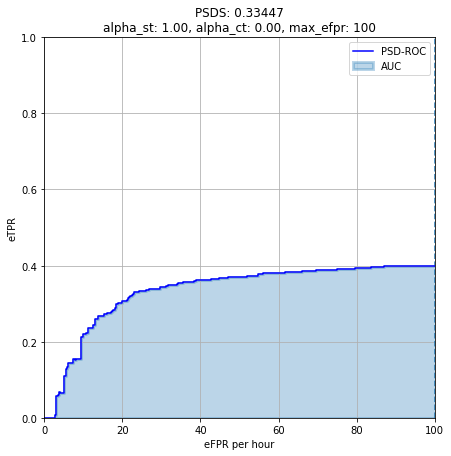

Scenario 1 - student, randomized ground-truth


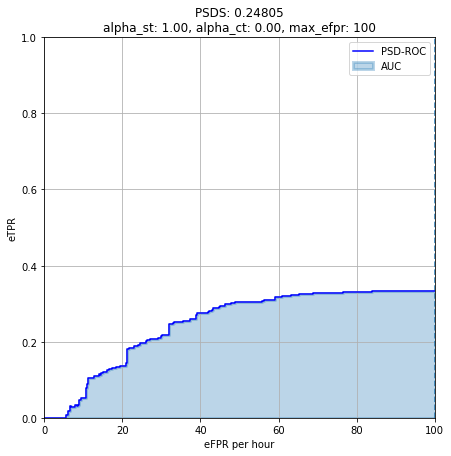

In [16]:
print("Scenario 1 - Student, original ground-truth")
plot_psd_roc(psds_scenario1_s)

print("Scenario 1 - student, randomized ground-truth")
plot_psd_roc(psds_scenario1_s_random)

As it is possible to observe, changing and randomizing the onset and offset value has quite a big impact on the PSDS Score. In particular, the higher the percentage we select, the higher the value that will be added to the onset and offset of the event, and the more significant is the drop we can observe in the PSDS metrics. 
It is interesting to analyze to what extent this will affect also the single classes. 

####  PSDS metrics per classes - Scenario 1. 

Analysis per class comparing the randomized ground-truth with the original values. 

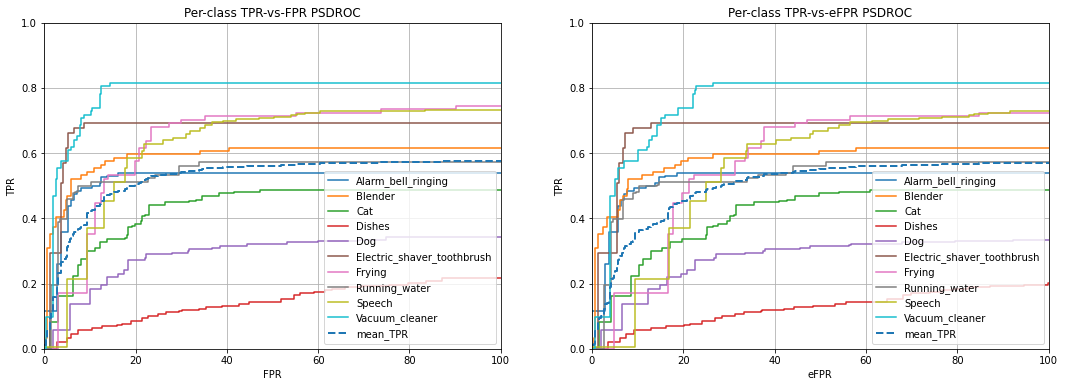

In [17]:
# PSDS metrics per classes considering the original ground-truth
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_t.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_t.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_t.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_t.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

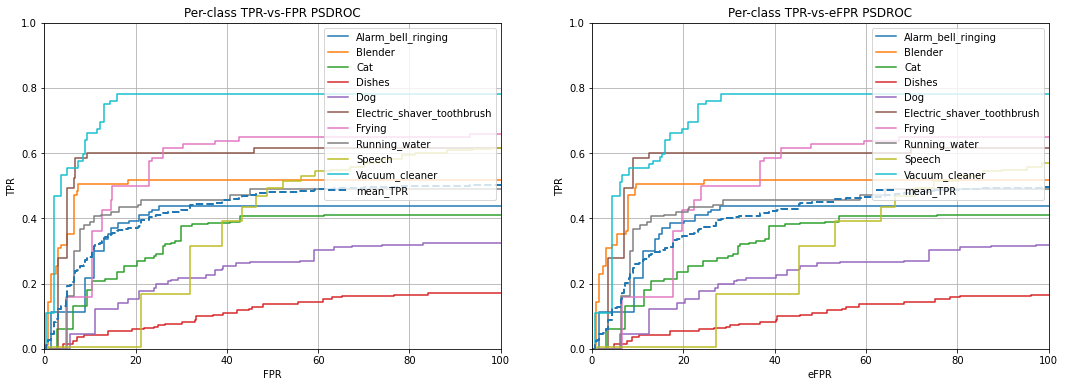

In [18]:
# PSDS metrics per classes considering the randomized ground-truth
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_t_random.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_t_random.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_t_random.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_t_random.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

As we observed with PSDS score and as it is possible to see from the plot, adding random values to the onset and offset leads to a decrease in performance. From the per classes plots, it is interesting to observe that the classes in which performances drop the most are the short events, such as Cat and Dog, but all the different events are affected, especially the Speech events. 

Now lets' run the same experiment for Scenario 2 and see the differences between the two scenarios. 

### PSDS Metrics - Scenario 2

Also for this case, we will run the experiment and compare the PSDS metrics considering the original gound-truth and the randomized ground-truth and analyze to what extend the randomized values impact the PSDS metrics. 

In [19]:
# PSDS metrics for scenario 2, original ground-truth
psds_scenario2_s, psds_eval_t = compute_psds_from_operating_points(
    test_psds_buffer_student, 
    gt, 
    durations, 
    dtc_threshold=0.1,
    gtc_threshold=0.1,
    cttc_threshold=0.3,
    alpha_ct=0.5,
    alpha_st=1
)

print("Psds scenario 2 student: {:.3f}".format(psds_scenario2_s.value))

# PSDS metrics for scenario 2, randomized ground-truth
psds_scenario2_s_random, psds_eval_t_random = compute_psds_from_operating_points(
    test_psds_buffer_student, 
    ref_df_v, 
    durations, 
    dtc_threshold=0.1,
    gtc_threshold=0.1,
    cttc_threshold=0.3,
    alpha_ct=0.5,
    alpha_st=1
)

print("Psds scenario 2 student randomized: {:.3f}".format(psds_scenario2_s_random.value))

Psds scenario 2 student: 0.533
Psds scenario 2 student randomized: 0.525


Scenario 2 - Student, original ground-truth


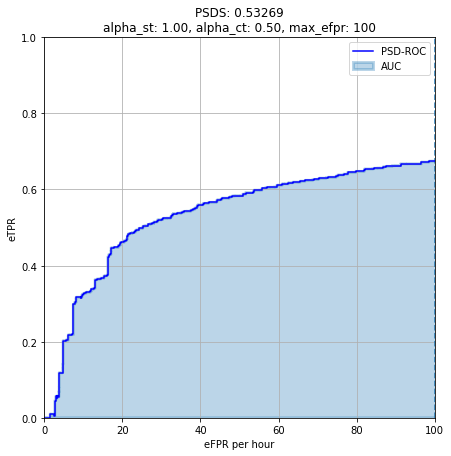

Scenario 2 - student, randomized ground-truth


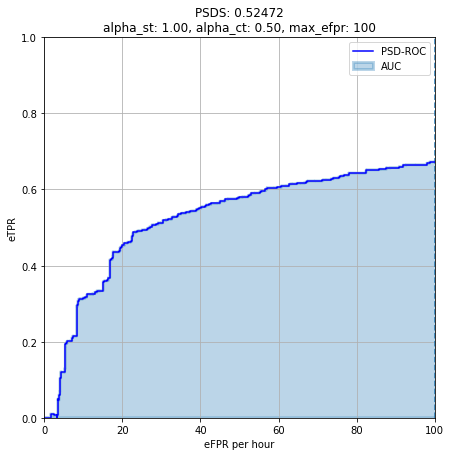

In [20]:
print("Scenario 2 - Student, original ground-truth")
plot_psd_roc(psds_scenario2_s)

print("Scenario 2 - student, randomized ground-truth")
plot_psd_roc(psds_scenario2_s_random)

The plots confirm that modifying the onset and offset values and considering this as the new ground-truth will have an impact on the PSDS metrics, in particular decreasing them. Comparing Scenario 1 and Scenario 2 though, Scenario 2 is less restrictive than Scenario and it has laxer constraints. In fact, the performances decrease less severely than in the previous Scenario. 
Let's see the impact it has on the different classes.


#### PSDS Metrics per classes - Scenario 2
Analysis per class comparing the randomized ground-truth with the original values. 

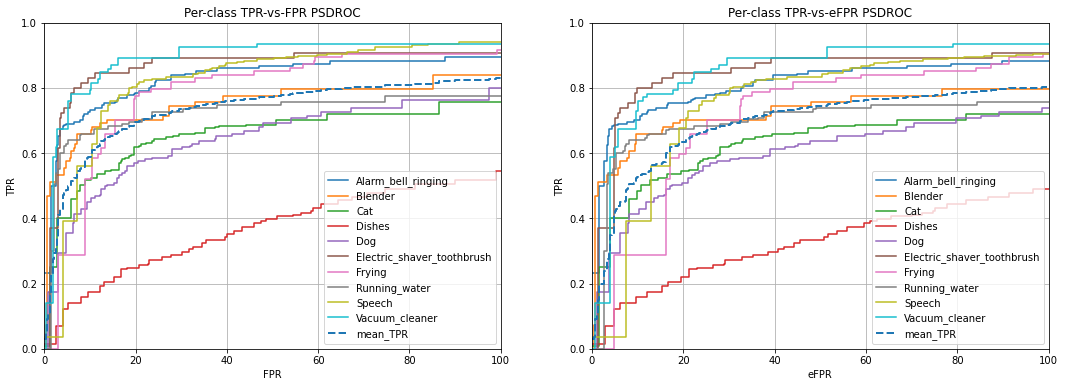

In [21]:
# PSDS metrics per classes for Scenario 2, original ground-truth
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_t.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_t.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_t.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_t.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

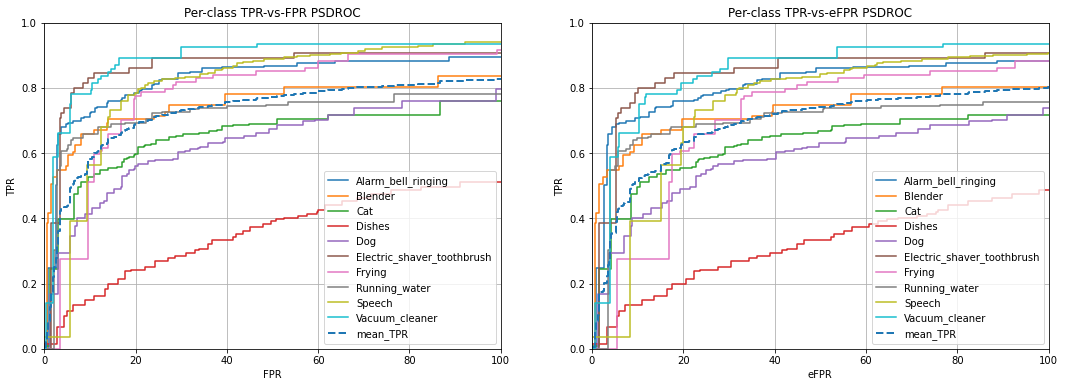

In [22]:
# PSDS metrics per classes for Scenario 2, randomized ground-truth
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

tpr_vs_fpr, _, _ = psds_eval_t_random.psd_roc_curves(alpha_ct=0.)
plot_per_class_psd_roc(tpr_vs_fpr, psds_eval_t_random.class_names, axes=axes[0], title="Per-class TPR-vs-FPR PSDROC", xlabel="FPR", xlim=100)

_, _, tpr_vs_efpr = psds_eval_t_random.psd_roc_curves(alpha_ct=0.5)
plot_per_class_psd_roc(tpr_vs_efpr, psds_eval_t_random.class_names, axes=axes[1], title="Per-class TPR-vs-eFPR PSDROC", xlabel="eFPR", xlim=100)

As we observed so far, we can conclude that adding random values to the onset and offset leads to a decrease in performance. From the per classes plots for the second scenario, it is interesting to observe in this case, the classes are more impact for lower `eFPR`, compared to the original ground-truth. This could be due to the fact that the scenario is more permissive. 

## REFERENCES

[1]: URL: https://github.com/DCASE-REPO/DESED_task/blob/master/PSDS_Eval/PSDS_Evaluation.ipynb

[2]: URL: https://github.com/audioanalytic/psds_eval/blob/master/jupyter/psds.ipynb
